# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

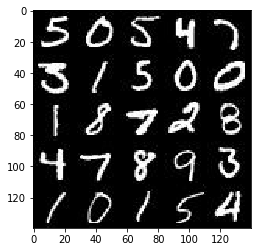

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

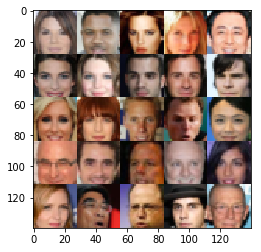

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32, [])
    
    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Parameters for the discriminator convnet
    kernel = 5
    stride = 2
    
    # Leaky ReLU helper
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha*x, x)

    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Use similar weight initialization than in DCGAN paper
        init = tf.truncated_normal_initializer(stddev=0.02)
        
        # First conv layer without batch normalization
        conv1 = tf.layers.conv2d(images, 64, kernel, stride, 'same',
                    kernel_initializer=init)
        conv1 = leaky_relu(conv1)
        # 14x14x64
        
        # Second conv layer
        conv2 = tf.layers.conv2d(conv1, 128, kernel, stride, 'same', use_bias=False,
                    kernel_initializer=init)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_relu(conv2)
        # 7x7x128
        
        # Third conv layer
        conv3 = tf.layers.conv2d(conv2, 256, kernel, stride, 'same', use_bias=False,
                    kernel_initializer=init)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_relu(conv3)
        # 4x4x256
        
        # Flatten and compute logits and output. Use dropout layer after logits.
        flat = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=init)
        logits = tf.layers.dropout(logits, rate=0.4, training=True)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #
    # For dropout rates in generator I used similar values than Srivastava
    # et. al. in their convnet for the SVHN dataset. The only
    # difference being that I left the input layer intact.
    #
    # Ref. http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf
    #

    # Parameters for the generator convnet
    kernel = 5
    
    # Leaky ReLU helper
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha*x, x)
    
    # Reuse variables only while not training, e.g. when sampling generated images
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # First, fully connected layer
        x = tf.layers.dense(z, 7*7*512, use_bias=False)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        x = tf.layers.dropout(x, 0.25, training=is_train)
        # 7x7x512
        
        # Second, transpose conv layer
        conv1 = tf.layers.conv2d_transpose(x, 256, kernel, 1, 'same', use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)        
        conv1 = leaky_relu(conv1)
        conv1 = tf.layers.dropout(conv1, 0.25, training=is_train)
        # 7x7x256
        
        # Third, transpose conv layer
        conv2 = tf.layers.conv2d_transpose(conv1, 128, kernel, 2, 'same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)        
        conv2 = leaky_relu(conv2)
        conv2 = tf.layers.dropout(conv2, 0.5, training=is_train)
        # 14x14x128
        
        # Fourth, transpose conv layer
        conv3 = tf.layers.conv2d_transpose(conv2, 64, kernel, 1, 'same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)        
        conv3 = leaky_relu(conv3)
        conv3 = tf.layers.dropout(conv3, 0.5, training=is_train)
        # 14x14x64
        
        # Last, transpose convolutional layer. No batch normalization, tanh activation.
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, kernel, 2, 'same')              
        output = tf.nn.tanh(logits)
        # 28x28xout_channel_dim
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generate fake images
    input_fake = generator(input_z, out_channel_dim)
    
    # Compute discriminator loss
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(input_fake, reuse=True)
    
    # Soft labels for discriminator. Using suggested value range in this page:
    # https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    labels_real = tf.random_uniform(tf.shape(d_output_real), 0.8, 1.1)
    labels_fake = tf.random_uniform(tf.shape(d_output_fake), 0.0, 0.3)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_fake))
    d_loss = d_loss_real + d_loss_fake
    
    # Compute generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get trainable variables per network
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Instruct Tensorflow to update population statistics of batch normalization layers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
                    d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
                    g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
import matplotlib.pyplot as plt

def print_losses(losses, interval):
    """
    Show training loss trend
    :param losses: losses for discriminator and generator
    """
    losses = np.array(losses)

    fig = plt.figure(figsize=(10,5))
    
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)    
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.grid(axis='y')
    plt.rc('grid', linestyle='dashed', color='black')
    plt.legend()
    _ = plt.xlabel('Batch number (x {})'.format(interval))
    _ = plt.ylabel('Loss')
    _ = plt.yticks(np.arange(1, 4+1, 1))

In [36]:
import os.path

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create placeholders. Not saving the placeholder for learning rate since we do not
    # want to change it dynamically    
    real_images, z_input, _ = model_inputs(*data_shape[1:], z_dim)
    # Create computation graph for losses
    d_loss, g_loss = model_loss(real_images, z_input, data_shape[-1])
    # Create optimizer operations
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Add ops to save and restore all the variables
    saver = tf.train.Saver(max_to_keep=1)
    checkpoint_dir = 'checkpoints'
    checkpoint_prefix = checkpoint_dir + '/model.ckpt'
    if not(os.path.isdir(checkpoint_dir)):
        os.mkdir(checkpoint_dir)
    
    # Parameters for statistics and sample images
    print_losses_every = 10
    show_samples_every = 100
    no_sample_images = 5*5
    # Counter of batches processed
    counter = 0
    # Losses
    losses = []    
    
    with tf.Session() as sess:
        
        # Load last restore point if existing
        if os.path.isfile(checkpoint_prefix+'.index'):
            saver.restore(sess, checkpoint_prefix)
        else:
            sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Increase counter
                counter += 1
                
                # Re-scale batch_images to -1,1 range (to match with generator output)                
                batch_images *= 2
                
                # Create as many noise samples as there are images in the batch
                z_batch = np.random.uniform(-1, 1, size=(batch_images.shape[0], z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_images: batch_images, z_input: z_batch})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, real_images: batch_images})
                
                # Print losses
                if counter % print_losses_every == 0:
                    train_loss_d = d_loss.eval({real_images: batch_images, z_input: z_batch})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses
                    losses.append((train_loss_d, train_loss_g))
                
                # Show sample images from generator
                if counter % show_samples_every == 0:
                    img_channels = batch_images.shape[-1]
                    show_generator_output(sess, no_sample_images, z_input,
                                          img_channels, data_image_mode)
                    # Save model
                    #save_path = saver.save(sess, checkpoint_prefix)
                    #print("Model saved in path: %s" % save_path)

    # Print losses
    print_losses(losses, print_losses_every)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5574... Generator Loss: 1.6399
Epoch 1/2... Discriminator Loss: 2.8474... Generator Loss: 0.5153
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 1.6667
Epoch 1/2... Discriminator Loss: 3.2217... Generator Loss: 3.9111
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 2.1544
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 2.4575... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 1.0137
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.5896
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.7383


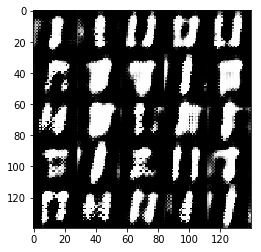

Epoch 1/2... Discriminator Loss: 1.6085... Generator Loss: 2.5665
Epoch 1/2... Discriminator Loss: 2.3054... Generator Loss: 3.6812
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.8651
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 1.0430
Epoch 1/2... Discriminator Loss: 1.4002... Generator Loss: 1.6122
Epoch 1/2... Discriminator Loss: 1.7135... Generator Loss: 0.4702
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.2482


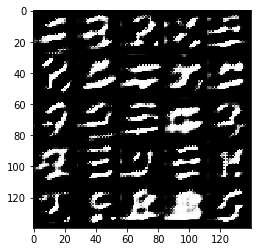

Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 1.0159
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 1.5549
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.8600
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 1.7737
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 1.3770


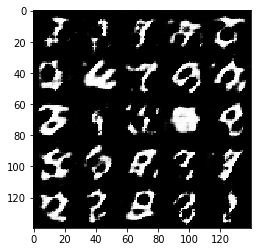

Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 1.0931
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 1.2703
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.4990
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.2306... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.8494


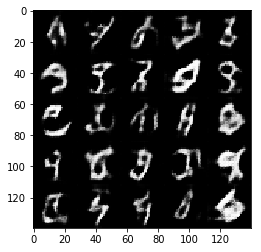

Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 0.8216
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.6786... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 1.2475... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.5417... Generator Loss: 1.0528


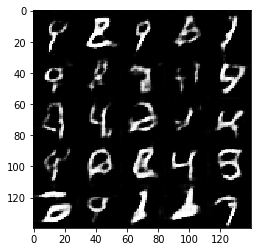

Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.8990
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 1.0471
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 1.5666... Generator Loss: 1.6593
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.2251... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.7585... Generator Loss: 0.4329


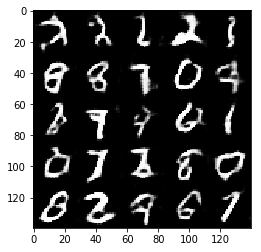

Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.6435
Epoch 2/2... Discriminator Loss: 1.2006... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.8541
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.9382
Epoch 2/2... Discriminator Loss: 1.2549... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.2686... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 1.2316... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.9690


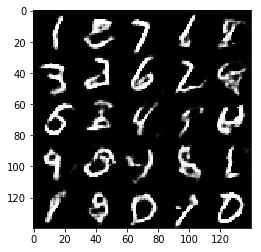

Epoch 2/2... Discriminator Loss: 1.2929... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.2254... Generator Loss: 0.8656
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 1.0020
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.4817
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.7550
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.9091


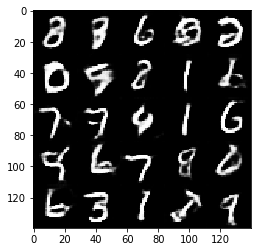

Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.6974
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.5262
Epoch 2/2... Discriminator Loss: 1.4727... Generator Loss: 1.4138
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.6012


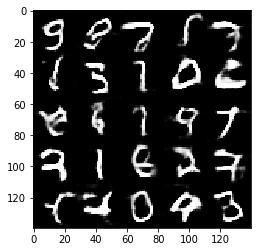

Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.8560... Generator Loss: 0.4206
Epoch 2/2... Discriminator Loss: 1.2382... Generator Loss: 0.7744


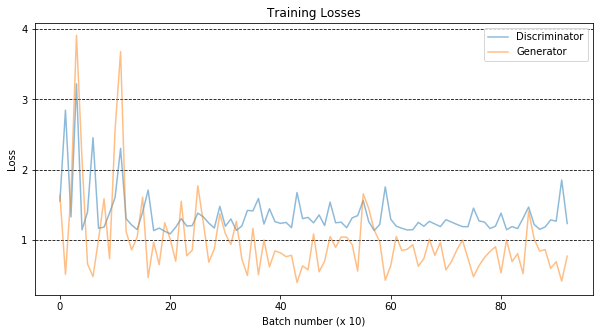

In [37]:
batch_size = 128
z_dim = 100
learning_rate = 0.01
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 5.4917
Epoch 1/1... Discriminator Loss: 1.8242... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 2.9999
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.7982
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.3770
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.9285
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 2.9802
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.0695


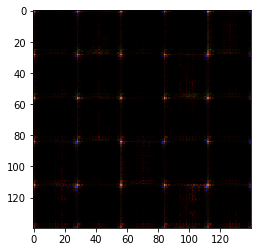

Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 2.1158... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.7167... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.8277... Generator Loss: 1.3971


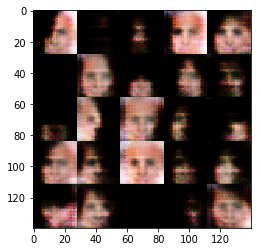

Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.9838... Generator Loss: 0.3733
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9586


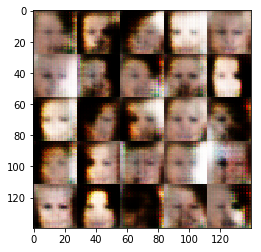

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 1.1102


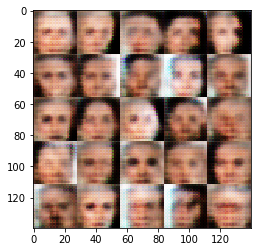

Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.8116... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.7900


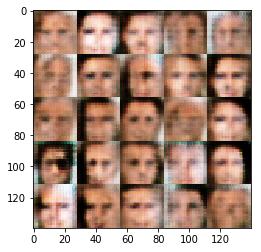

Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 1.5416
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 1.0211


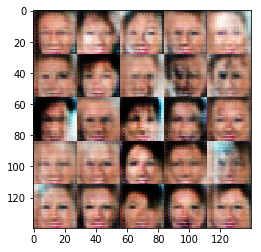

Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 1.1731


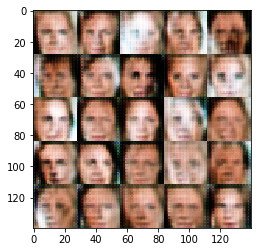

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.5666
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.5055


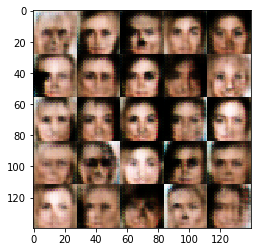

Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.2713
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.4847
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.6876


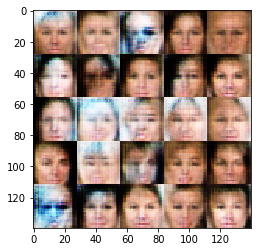

Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 1.3805
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.7660


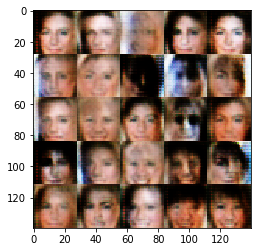

Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.6779


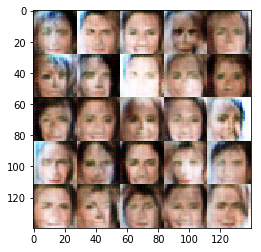

Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.5105... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.0565


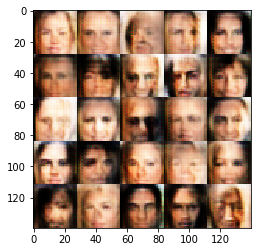

Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 1.3264
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 1.0293


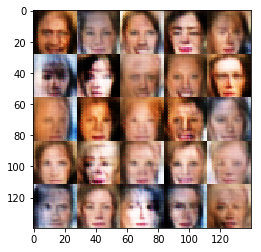

Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.4416
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.9638


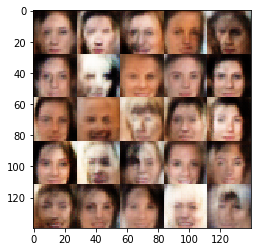

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7460


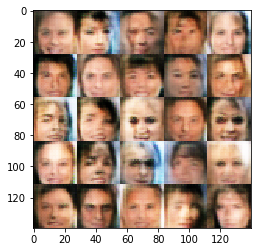

Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 1.6022
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 1.0122
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 1.3795


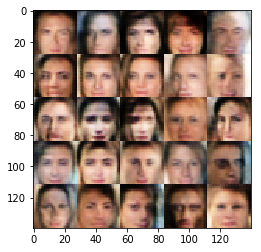

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.7753... Generator Loss: 1.2701


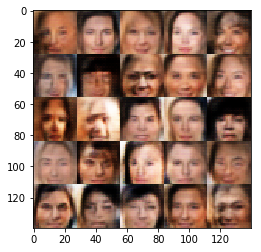

Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.9363


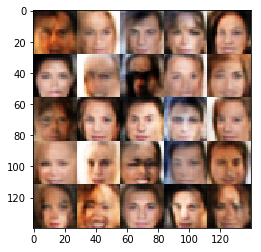

Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.5085


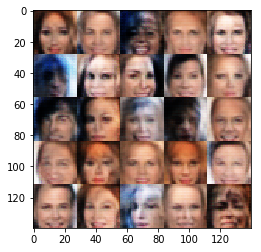

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.0408


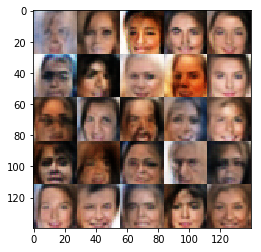

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 1.2905
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8892


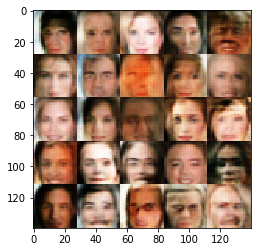

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.4989
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.7847


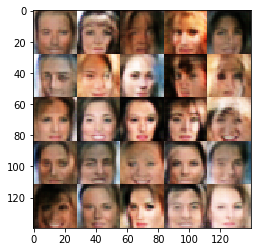

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8321


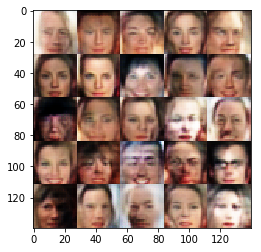

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9350


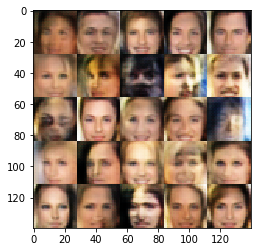

Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.0712
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 1.3266


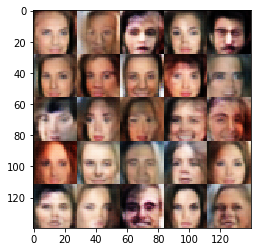

Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6605


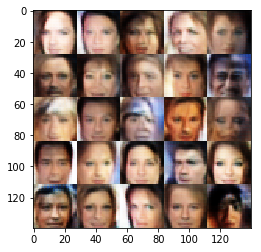

Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.5478


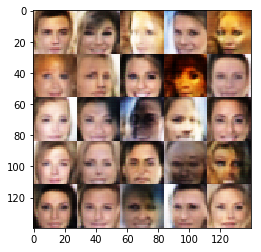

Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.8238... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.6262... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0635


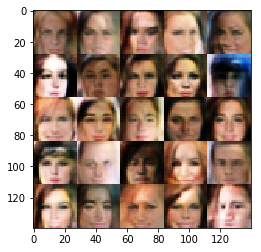

Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9461
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6357


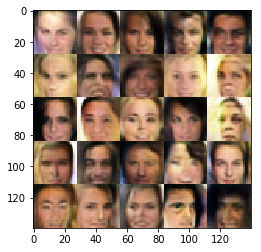

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.9163


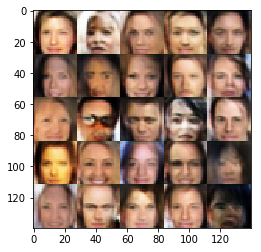

Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.5675


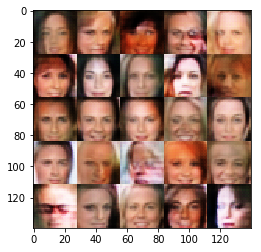

Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7275


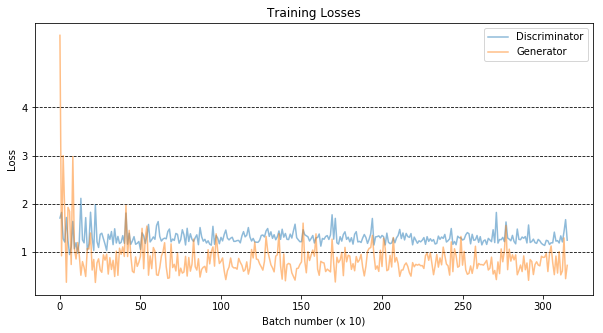

In [40]:
batch_size = 64
z_dim = 256
learning_rate = 0.001
beta1 = 0.5

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.